# CNNs for image classification

## Step 1: Data Loading and Preprocessing

### 1.1 Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

### Define Data Transformations

In [2]:
# Define training data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Define test data normalization
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

### 1.3 Load the CIFAR-10 Dataset

In [3]:
# Download and load training data
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

# Download and load test data
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


### 1.4 Split the Data

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

### 1.5 Verify Data Loading and Preprocessing

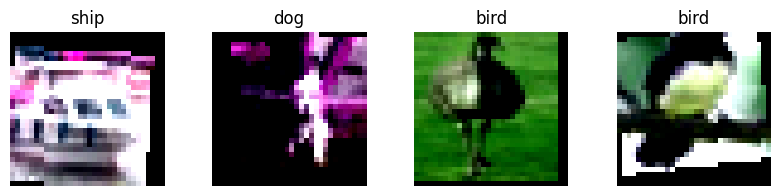

In [7]:
# Function to unnormalize, clip, and show an image
def imshow(img):
    img = img * 0.2023 + 0.4914  # Unnormalize using the mean and std deviation
    img = torch.clamp(img, 0, 1)  # Clip the values to be within [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Display images with labels
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for idx, ax in enumerate(axes):
    img = images[idx] / 2 + 0.5  # Unnormalize
    img = torch.clamp(img, 0, 1)  # Clip the values to be within [0, 1]
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
    ax.axis('off')
plt.show()

### Citation
Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.